<a href="https://colab.research.google.com/github/phuri7987/229352-StatisticalLearning-Lab/blob/main/Lab08_Neural_Networks_640510703.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #8

In [10]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [11]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [12]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

In [13]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader

In [14]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

#### Do the same for the test images

In [15]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [16]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


#### Visualize the first four images in the batch

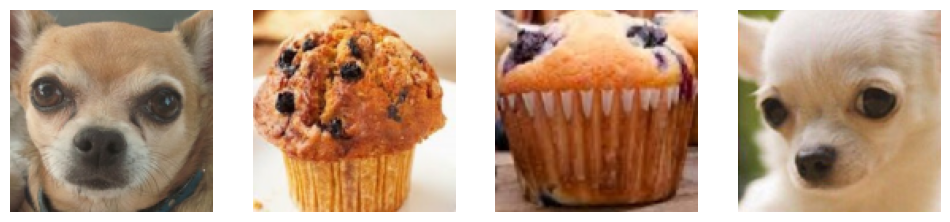

tensor([0, 1, 1, 0])


In [17]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  
  
[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [20]:
class SimpleLogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(SimpleLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        z = self.linear(x)
        y_hat = self.sigmoid(z)
        return y_hat


### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [22]:
model = SimpleLogisticRegression(input_dim=3*128*128)
criterion = nn.BCELoss()

#### Manually setting initial weights to zero for demonstration

In [23]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [24]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [25]:
learning_rate = 1e-3

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [28]:
for x_batch, y_batch in train_loader:
  pass

#### Make a prediction on the minibatch (Forward pass)

In [40]:
y_hat = model(x_batch.view(x_batch.size(0), -1))

#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [41]:
# Compute the loss
y_hat = y_hat[:, 0]
y = y_batch.to(torch.float32)
loss = criterion(y_hat, y)

#### Calculate the gradient (Backward pass)

In [42]:
loss.backward()

In [43]:
model.parameters()

<generator object Module.parameters at 0x7b0b84913680>

#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [44]:
# Manually update the weights using the gradient descent rule
with torch.no_grad():
    for param in model.parameters():
        param -= learning_rate * param.grad

# Zero the gradients after updating
model.zero_grad()

#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [45]:
with torch.no_grad():
  for X, y in val_loader:
    y_hat = model(X.view(X.size(0), -1))
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

In [46]:
print(train_losses)
print(val_losses)

[]
[1.0175230503082275]


#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

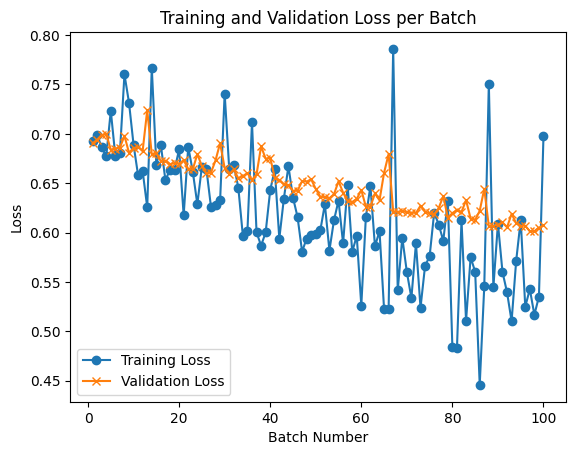

In [48]:
model = SimpleLogisticRegression(input_dim=3*128*128)
criterion = nn.BCELoss()

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

learning_rate = 1e-4

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X.view(X.size(0), -1))
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X.view(X.size(0), -1))
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss.item())

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

1.

In [50]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)     # no activation here (จะใช้ CrossEntropyLoss)
        return x

2.

In [52]:
import torch.optim as optim

# สมมติ input_dim = 3*224*224 (flattened image)
input_dim = 3*128*128 # Corrected input_dim to match the image size

model = SimpleNN(input_dim, num_classes=2) # Initialize SimpleNN model

criterion = nn.CrossEntropyLoss()

learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]

for lr in learning_rates:
    optimizer = optim.SGD(model.parameters(), lr=lr)
    print(f"\nTraining with learning rate = {lr}")

    for epoch in range(5):  # ตัวอย่าง train 5 epochs
        for x_batch, y_batch in train_loader: # Changed 'dataloader' to 'train_loader'
            x_batch = x_batch.view(x_batch.size(0), -1)  # flatten
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Training with learning rate = 0.01
Epoch 1, Loss: 0.6834
Epoch 2, Loss: 0.6736
Epoch 3, Loss: 0.7044
Epoch 4, Loss: 0.6970
Epoch 5, Loss: 0.6032

Training with learning rate = 0.001
Epoch 1, Loss: 0.6178
Epoch 2, Loss: 0.6059
Epoch 3, Loss: 0.6234
Epoch 4, Loss: 0.5565
Epoch 5, Loss: 0.4957

Training with learning rate = 0.0001
Epoch 1, Loss: 0.5915
Epoch 2, Loss: 0.5854
Epoch 3, Loss: 0.5234
Epoch 4, Loss: 0.5742
Epoch 5, Loss: 0.4922

Training with learning rate = 1e-05
Epoch 1, Loss: 0.6054
Epoch 2, Loss: 0.5138
Epoch 3, Loss: 0.4399
Epoch 4, Loss: 0.5661
Epoch 5, Loss: 0.5845


2.1) จากผลลัพธ์ที่ให้มา Learning Rate ที่ 0.0001 (1e-4) ดูเหมือนจะเป็นค่าที่ดีที่สุดในบรรดาค่าที่ทดสอบ การเทรนด้วย Learning Rate นี้ทำให้ค่า Loss ลดลงอย่างต่อเนื่องในแต่ละ Epoch และได้ค่า Loss สุดท้ายที่ต่ำที่สุดคือ 0.4922 เมื่อเทียบกับ Learning Rate อื่นๆ แม้ว่า 0.001 จะแสดงแนวโน้มการลดลงเช่นกัน แต่ 0.0001 ดูเหมือนจะลู่เข้าสู่ค่า Loss ที่ต่ำกว่าเล็กน้อย

2.2) ถ้า Learning Rate ใหญ่เกินไป ค่า Training Loss อาจจะ แกว่งไปมาหรือไม่ก็เพิ่มขึ้นได้ เนื่องจากขั้นตอนที่ใหญ่เกินไปในการทำ Gradient Descent อาจทำให้ข้ามจุดต่ำสุดของฟังก์ชัน Loss ไป ในผลลัพธ์ด้วย Learning Rate 0.01 ค่า Loss มีความผันผวนและไม่ได้ลดลงอย่างสม่ำเสมอ

2.3) ถ้า Learning Rate เล็กเกินไป กระบวนการเทรนอาจจะ ช้ามาก และอาจใช้เวลานานกว่าจะลู่เข้าสู่จุดต่ำสุดของฟังก์ชัน Loss ในบางกรณี อาจติดอยู่ใน Local Minimum ได้ เมื่อดูผลลัพธ์สำหรับ Learning Rate 1e-05 แม้ว่าค่า Loss จะลดลง แต่ก็ไม่ถึงค่าที่ต่ำเท่ากับเมื่อใช้ 0.0001 ภายในจำนวน Epoch เท่ากัน ซึ่งแสดงให้เห็นถึงการลู่เข้าที่ช้ากว่า

3.

In [53]:
# Use this code to calculate test accuracy
with torch.no_grad():
  test_batches = iter(test_loader)
  X, y = next(test_batches)
  y_hat = model(X.view(X.size(0), -1)) # Flatten the input
  y_hat = y_hat[:, 0]
  y_hat = (y_hat > 0.5).float()  # the predictions
  # Compute accuracy
  correct_predictions = (y_hat == y.float()).sum().item()
  accuracy = correct_predictions / len(y)
  print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.4667


4.

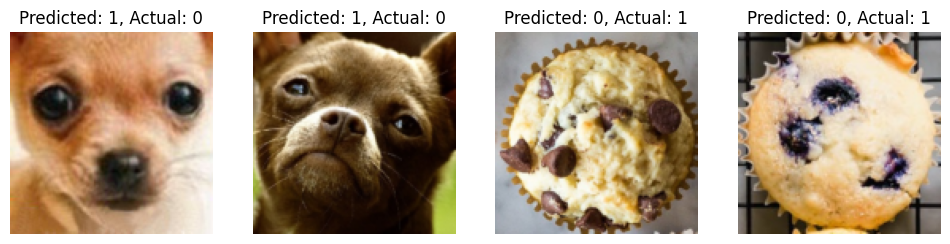

In [54]:
# Get predictions and true labels for the test set
with torch.no_grad():
    test_images, test_labels = next(iter(test_loader))
    test_outputs = model(test_images.view(test_images.size(0), -1))
    # Assuming the model output is probabilities or logits for 2 classes
    # If using BCELoss with sigmoid output, y_hat is already probabilities for class 1
    # If using CrossEntropyLoss, apply softmax to get probabilities and get the predicted class
    if isinstance(criterion, nn.BCELoss):
        test_predictions = (test_outputs[:, 0] > 0.5).float()
    elif isinstance(criterion, nn.CrossEntropyLoss):
        _, test_predictions = torch.max(test_outputs, 1)
        test_predictions = test_predictions.float()


# Find incorrectly classified images
incorrect_indices = (test_predictions != test_labels.float()).nonzero(as_tuple=True)[0]

# Display at least four incorrectly classified images
num_images_to_display = min(len(incorrect_indices), 4)

if num_images_to_display > 0:
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(12, 4))
    if num_images_to_display == 1:
        axes = [axes] # Make it iterable for consistency

    for i in range(num_images_to_display):
        img_index = incorrect_indices[i]
        img = test_images[img_index].permute(1, 2, 0).numpy() # Convert from (C, H, W) to (H, W, C) and to numpy
        axes[i].imshow(img)
        axes[i].set_title(f"Predicted: {int(test_predictions[img_index].item())}, Actual: {int(test_labels[img_index].item())}")
        axes[i].axis('off')
    plt.show()
else:
    print("No incorrectly classified images found in the test set.")